In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

The thermal conductivity equation:
$\frac{\partial T}{\partial t} - \frac{{\partial}^2 T}{\partial x^2} = 0$

Assume $ T(t, x) = 2 + e^{-4 \pi^2 t} sin(2\pi x) + e^{-16\pi^2 t} cos(4\pi x)$, $x\in[0,1], t\in[0,0.05]$
$\\$Boundary condition $T_0 = T(0, x) = 2 + sin(2\pi x) + cos(4\pi x)$

In [71]:
#define amount of sample points
N = 2000

In [72]:
#in the beginning we plot graph of the thermal conductivity process
def f_real(t, x):
    return (2 + torch.exp(-4*(torch.pi**2)*t)*torch.sin(2*torch.pi*x) + torch.exp(-16*(torch.pi**2)*t)*torch.cos(4*torch.pi*x))

In [73]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self,input_layer=2,h1=64,h2=64,h3=64,output_layer=1):
        super().__init__()
#         activation = nn.Tanh
        self.fc1 = nn.Linear(input_layer,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.fc4 = nn.Linear(h3,output_layer)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        x = F.gelu(self.fc4(x))
        
        return x

In [74]:
torch.manual_seed(123)

In [75]:
x_phys = torch.rand(N).view(-1,1).requires_grad_(True)
t_ = 0.05 * torch.rand(N).view(-1,1)
t_phys = t_.requires_grad_(True)
points = torch.stack((t_phys,x_phys), -1)
points_bc = torch.stack((torch.zeros(N,1), x_phys), -1)

pinn = PINN()
optimizer = torch.optim.SGD(pinn.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,
#     patience=1,
#     threshold=1e-2,
#     threshold_mode='rel',
)

Loss1 = $\frac{1}{N} \sum_{i=1}^{N}(T(t_i, x_i)- f_{PINN}(t_i, x_i))^2$

Loss2 = $\frac{1}{N} \sum_{i=1}^{N}(T_0(x_i)- f_{PINN}(0, x_i))^2$

Loss3 = $\frac{1}{N} \sum_{i=1}^{N}(\frac{\partial}{\partial t}f_{PINN}(t_i, x_i) - \frac{{\partial}^2 }{\partial x^2}f_{PINN}(t_i, x_i))^2$

In [76]:
"""
Neural network training using sum of MSE, boundary condition and partial dirivatives.
"""
epochs = 5000
# previous_loss = float('inf')
# tolerance = 1e-2
# num_iter_with_small_changes = 0
# max_iter_with_small_changes = 10
# max_learning_rate = 1.5


for i in range(epochs):
#     optimizer.zero_grad()
    
    #compute MSE of T(t,x) and points that were pridicted by PINN
    network = pinn.forward(points)
    network_bc = pinn.forward(points_bc)
    
    loss1 = torch.mean((f_real(t_phys, x_phys) - network)**2)
    loss2 = torch.mean((f_real(torch.zeros_like(x_phys), x_phys) - network_bc)**2)
    
    #compute loss using derivatives
    dt = torch.autograd.grad(network, t_phys, torch.ones_like(network), create_graph=True)[0]
    dx = torch.autograd.grad(network, x_phys, torch.ones_like(network), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx, x_phys, torch.ones_like(dx), create_graph=True)[0]

    loss3 = torch.mean((dt - dx2)**2)
    
    loss = loss2 + loss3 + loss1
    loss.backward()
    
    optimizer.step()
    scheduler.step(loss)
    
#     delta_loss = previous_loss - loss
    
#     if delta_loss <= tolerance:
#         num_iter_with_small_changes += 1
#     else:
#         num_iter_with_small_changes = 0

#     if num_iter_with_small_changes >= max_iter_with_small_changes:
#         current_lr = optimizer.param_groups[0]['lr']
#         new_lr = current_lr * 1.7
#         optimizer.param_groups[0]['lr'] = max(new_lr, max_learning_rate)  # Увеличьте learning_rate в 1.7 раз
#         num_iter_with_small_changes = 0

#     previous_loss = loss
    
    if i % 100 == 0:
        print(f'epoch: {i}, loss: {loss}, learning_rate: {optimizer.param_groups[0]["lr"]}')

print(f'epoch: {i}, loss: {loss}, learning_rate: {optimizer.param_groups[0]["lr"]}')


epoch: 0, loss: 8.751119613647461, learning_rate: 0.1
epoch: 100, loss: 1.2268465757369995, learning_rate: 0.005764800999999997
epoch: 200, loss: 1.2355479001998901, learning_rate: 0.0003323293056960096
epoch: 300, loss: 1.2081081867218018, learning_rate: 1.3410686196639624e-05
epoch: 400, loss: 1.2083954811096191, learning_rate: 5.411695603795198e-07
epoch: 500, loss: 1.2083165645599365, learning_rate: 3.119734822845415e-08
epoch: 600, loss: 1.208277702331543, learning_rate: 3.119734822845415e-08
epoch: 700, loss: 1.2082208395004272, learning_rate: 3.119734822845415e-08
epoch: 800, loss: 1.2081472873687744, learning_rate: 3.119734822845415e-08
epoch: 900, loss: 1.2080564498901367, learning_rate: 3.119734822845415e-08
epoch: 1000, loss: 1.2079499959945679, learning_rate: 3.119734822845415e-08
epoch: 1100, loss: 1.207829236984253, learning_rate: 3.119734822845415e-08
epoch: 1200, loss: 1.20769464969635, learning_rate: 3.119734822845415e-08
epoch: 1300, loss: 1.2075486183166504, learning

KeyboardInterrupt: 

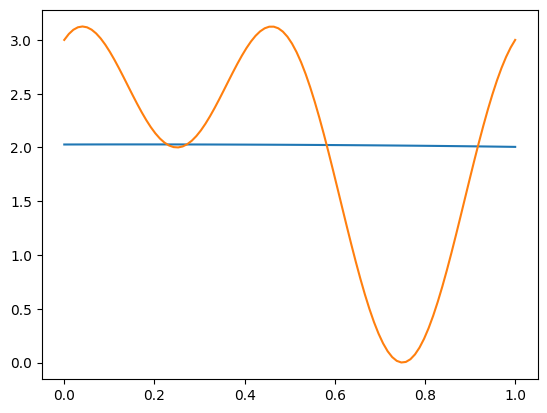

In [77]:
xs = torch.linspace(0, 1, 100)
ts = torch.zeros(100)
graph_points = torch.stack((ts, xs), axis=-1)
#print(graph_points)
T_nn = pinn.forward(graph_points).view(100)
plt.plot(xs.numpy(), T_nn.detach().numpy())
T_real = f_real(ts, xs).view(100)
plt.plot(xs.numpy(), T_real.numpy())

plt.plot()
plt.show()

In [12]:
print(loss)

tensor(2.1527, grad_fn=<AddBackward0>)


In [52]:
"""
Neural network training using only partial dirivatives and boundary condition.
"""
pinn_new = PINN()
optimizer_new = torch.optim.Adam(pinn_new.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 60, gamma=0.5)
scheduler_new = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_new, 'min', factor=0.75)
epochs = 500

for i in range(epochs):
    #compute MSE of T(t,x) and points that were pridicted by PINN
    network_new = pinn_new.forward(points)
    y_bc_new = pinn_new.forward(points_bc)
    
    loss1 = torch.mean((f_real(t_phys, x_phys) - network)**2)
    loss2 = torch.mean((f_real(torch.zeros_like(x_phys), x_phys) - y_bc_new)**2)
    
    #compute loss using derivatives
    dt = torch.autograd.grad(network, t_phys, torch.ones_like(network), create_graph=True)[0]
    dx = torch.autograd.grad(network, x_phys, torch.ones_like(network), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx, x_phys, torch.ones_like(dx), create_graph=True)[0]
    loss3 = torch.mean((dt - dx2)**2)
    
    
    loss2_new = torch.mean((f_real(torch.zeros_like(x_data), x_data) - y_bc_new)**2)
    
    #compute loss using derivatives
    dt_new = torch.autograd.grad(network_new, t_phys, torch.ones_like(network_new), create_graph=True)[0]
    dx_new = torch.autograd.grad(network_new, x_phys, torch.ones_like(network_new), create_graph=True)[0]
    dx2_new = torch.autograd.grad(dx_new, x_phys, torch.ones_like(dx_new), create_graph=True)[0]
    loss3_new = torch.mean((dt_new - dx_new)**2)
    
    loss_new = loss2_new + loss3_new
    loss_new.backward()
    
    optimizer_new.step()
    scheduler_new.step(loss)
    if i % 50 == 0:
        print(f'epoch: {i}\tamount of loss: {loss_new}\t')

epoch: 0	amount of loss: 4.951014041900635	
epoch: 50	amount of loss: 1.277353286743164	
epoch: 100	amount of loss: 1.3161898851394653	
epoch: 150	amount of loss: 1.2619175910949707	
epoch: 200	amount of loss: 1.1619625091552734	
epoch: 250	amount of loss: 1.1108143329620361	
epoch: 300	amount of loss: 1.0971288681030273	
epoch: 350	amount of loss: 1.093517541885376	
epoch: 400	amount of loss: 1.0925331115722656	
epoch: 450	amount of loss: 1.0922656059265137	


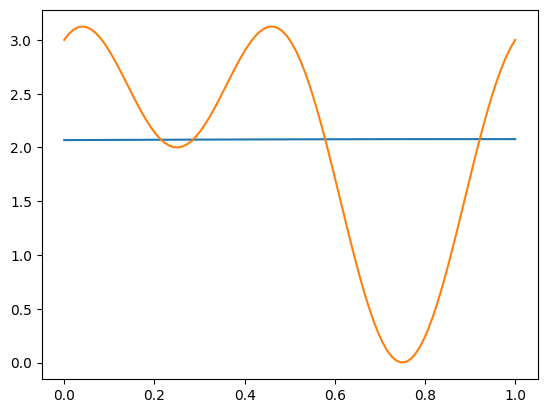

In [21]:
xs = torch.linspace(0, 1, 100)
ts = torch.zeros(100)
graph_points = torch.stack((ts, xs), axis=-1)
#print(graph_points)
T_nn = pinn.forward(graph_points).view(100)
plt.plot(xs.numpy(), T_nn.detach().numpy())
T_real = f_real(ts, xs).view(100)
plt.plot(xs.numpy(), T_real.numpy())

plt.plot()
plt.show()

In [20]:
print(loss)

tensor(0.9646, grad_fn=<AddBackward0>)
